# **w261 Final Project - Clickthrough Rate Prediction**

Team Number:19

Team Members: Steve Dille, Naga Akkineni, Joanna Yu, Pauline Wang

Fall 2019, section [Your section numbers>]

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/w261_KSA/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# I. Question Formulation
*Introduce the goal of your analysis. What questions will you seek to answer, why do people perform this kind of analysis on this kind of data? Preview what level of performance your model would need to achieve to be practically useful*

- introduction of clickthrough and industry application
- what do we want to solve? 
- why is it important?
- how to we benchmark the perormance of our model? 

(Steve's Write up)
Our goal in this analysis is to build a model that can predict advertising click through rates (CTR).  This is an enormously valuable goal which is why there is so much investment in machine learning and data science in this area.  Being able to have better predictions of what are the factors that drive clickthrough rates is valuable to the buy side (advertising buyers) and the sell side (ad platforms, publishers…).  If advertisers have better predictive power of clickthrough conversion rates, they can use this to determine expected sales from a campaign, where to advertise, how much they can spend for profitable investment, which platforms and publishers to advertise with etc..  On the sell side, if you could model and predict conversions, you could adjust pricing models to suit the advertisers who are interested in your ad products and achieve higher revenue and greater customer satisfaction.

In this situation, our EDA shows the ground truth is that 25.62% of the rows of data converted to a click through.  So a baseline model could be built that always predicts that each data row is not a click through which would result in model accuracy of 74.38%. For us, we would need to achieve accuracy of 74.38% or more for this to be a worthwhile investment of model building resources.   This would be a practically useful model as the accuracy could be used as an expected value over the long run of advertising campaigns in downstream calculations of advertising return on investment calculations.

# II. Algorithm Explanation
*Create your own toy example that matches the dataset provided and
use this toy example to explain the math behind the algorithm that you will perform.*

We choose decision tree/random forest as our algorithm for the Criteo project because of the nature of the dataset we are given.  First of all, the data set contains both continuous numeric features and categorical features.   Second, as illustrated in the subsequent EDA section, the data set contains many missing values.   Decision tree/random forest algorithms are known to be robust handing data set with mixed features and missing values.  Last but not least, we are not given any information about what the features represent, and therefore, we want to keep the data preprocessing and feature selection to a minimum by simply grouping feature values in representative bins. 



##Toy Data Preprocessing

In this section, we explore and experiment different ways of preprocess the toy data.   The methodology that gives us the best result in terms of its prediction of the CTR of the toy validation set will be replicated on the train.txt data set in the Algorithm Implementation section.  

We separate our data processing steps by the types of features we have, numeric and categorical. 


In [0]:
#import library
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO
import pydotplus
import graphviz
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [0]:
# We create a toy data set that's about 0.01% of the train data
!cat 'gdrive/My Drive/w261_KSA/toy_naga.txt' | awk 'BEGIN {srand()} !/^$/ { if (rand() <= .01) print $0}' > 'gdrive/My Drive/w261_KSA/toy_pauline.txt'

In [0]:
# Upload toy_train.txt to panda dataframe from Google Share Drive
df=pd.read_csv('gdrive/My Drive/w261_KSA/toy_pauline.txt', sep='\t',names=['Label','I-1','I-2','I-3','I-4','I-5','I-6','I-7','I-8','I-9','I-10','I-11','I-12','I-13','C-1','C-2','C-3','C-4','C-5','C-6','C-7','C-8','C-9','C-10','C-11','C-12','C-13','C-14','C-15','C-16','C-17','C-18','C-19','C-20','C-21','C-22','C-23','C-24','C-25','C-26'])

In [0]:
# Quick exploratory data analysis - we take a look at the dataframe 
df.head(n=15)

,Label,I-1,I-2,I-3,I-4,I-5,I-6,I-7,I-8,I-9,I-10,I-11,I-12,I-13,C-1,C-2,C-3,C-4,C-5,C-6,C-7,C-8,C-9,C-10,C-11,C-12,C-13,C-14,C-15,C-16,C-17,C-18,C-19,C-20,C-21,C-22,C-23,C-24,C-25,C-26
0,0,NaN,161,138.0,1.0,77788.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,05db9164,4322636e,c569d2b8,3d7f7f11,30903e74,NaN,dabb20e7,0b153874,7cc72ec2,461a7e93,138856a5,7131ac7a,79e86662,1adce6ef,117b1660,3eb1b977,1e88c74f,9d3171e9,21ddcdc9,5840adea,24d2280e,NaN,3a171ecb,9bd7cac5,ea9a246c,984e0db0
1,0,NaN,60,61.0,3.0,117303.0,NaN,NaN,9.0,NaN,NaN,NaN,NaN,9.0,5a9ed9b0,38d50e09,02492c79,cbb8003e,25c83c98,7e0ccccf,6cd97108,51d76abe,7cc72ec2,3b08e48b,62cdafdf,4e5772c5,2e551bbe,1adce6ef,e2c18d5a,9460a022,776ce399,582152eb,21ddcdc9,5840adea,fb35855f,NaN,be7c41b4,9d8d9d7c,001f3601,aa5f0a15
2,0,1.0,0,54.0,6.0,50.0,7.0,1.0,7.0,7.0,1.0,1.0,NaN,7.0,5a9ed9b0,4f25e98b,bdbabdc9,1169bfb5,25c83c98,7e0ccccf,7fffde06,0b153874,a73ee510,83544135,f22957ba,795707b0,3950253e,1adce6ef,17d9b759,27baa113,d4bb7bd8,7ef5affa,77129a30,b1252a9d,44e92dfc,ad3062eb,3a171ecb,916f087d,e8b83407,f2e7a9e0
3,1,NaN,1,13.0,5.0,35396.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN,5.0,68fd1e64,04e09220,b1ecc6c4,5dff9b29,25c83c98,7e0ccccf,105b9154,5b392875,a73ee510,3b08e48b,768f3a24,2436ff75,1268ae40,07d13a8f,f6b23a53,f4ead43c,e5ba7672,6fc84bfb,NaN,NaN,4f1aa25f,c9d4222a,423fab69,ded4aac9,NaN,NaN
4,0,NaN,11,17.0,4.0,4563.0,NaN,0.0,10.0,4.0,NaN,0.0,NaN,4.0,05db9164,55e0a784,d88496ea,66ca6f9c,25c83c98,7e0ccccf,eee2db9e,c8ddd494,a73ee510,3b08e48b,c6240b97,a8ab776a,022a36e3,1adce6ef,573054c2,949b03ad,3486227d,6c5555bd,1d04f4a4,b1252a9d,95f07388,NaN,32c7478e,a9a2ac1a,9b3e8820,4b6a03d5
5,0,0.0,6,1.0,5.0,1854.0,57.0,8.0,22.0,174.0,0.0,2.0,0.0,5.0,be589b51,a796837e,08de7b18,97ce69e9,25c83c98,7e0ccccf,d2dbdfe6,5b392875,a73ee510,015ac893,2b9c7071,c5011072,1aa94af3,cfef1c29,98eddd86,5a9431f3,3486227d,e90118d1,NaN,NaN,e754c5e1,NaN,32c7478e,8fc66e78,NaN,NaN
6,0,NaN,1,10.0,3.0,1942.0,16.0,7.0,8.0,34.0,NaN,3.0,NaN,3.0,05db9164,4e8d18ed,f2982b09,b458bb1a,30903e74,13718bbd,0dec8040,5b392875,a73ee510,723d6c0f,a9b84bd5,d4cbac15,cdc2ccda,07d13a8f,8d016df5,a67f117e,e5ba7672,47e4d79e,2f4b9dd2,b1252a9d,1b1392f9,NaN,c7dc6720,64fbb706,e8b83407,4821aad6
7,0,NaN,18,13.0,10.0,13844.0,NaN,0.0,12.0,73.0,NaN,0.0,NaN,10.0,68fd1e64,512fdf0c,003f419b,ff852091,4cf72387,fbad5c96,9099e7b5,0b153874,a73ee510,3b08e48b,70d4d706,349450bc,b6a6a31e,07d13a8f,aa322bcf,6615ffe6,776ce399,fd3919f9,21ddcdc9,b1252a9d,3dd38d65,NaN,32c7478e,c2fe6ca4,724b04da,0015d4de
8,1,0.0,6,5.0,3.0,2210.0,130.0,37.0,20.0,264.0,0.0,7.0,0.0,3.0,05db9164,38a947a1,1e7a321a,b0f95598,4cf72387,13718bbd,96d443af,0b153874,a73ee510,edccdfed,35dc8759,1801a4a0,c1618056,1adce6ef,555cd321,e5f3b345,3486227d,5f2d60ad,NaN,NaN,57272c15,NaN,423fab69,24db27bb,NaN,NaN
9,0,NaN,5,67.0,1.0,10810.0,63.0,0.0,1.0,69.0,NaN,0.0,NaN,1.0,05db9164,8947f767,8dd2cbce,9b096029,25c83c98,fbad5c96,496b90e2,0b153874,a73ee510,a3d4e5bf,f1911847,6324e4bd,2e9930bc,07d13a8f,2c14c412,c408db33,e5ba7672,bd17c3da,21ddcdc9,b1252a9d,d4a99654,c0061c6d,3a171ecb,05427247,010f6491,dbcaded1


In [0]:
# Take a look at the summary statistics of the toy dataset
df.describe(include ='all')

,Label,I-1,I-2,I-3,I-4,I-5,I-6,I-7,I-8,I-9,I-10,I-11,I-12,I-13,C-1,C-2,C-3,C-4,C-5,C-6,C-7,C-8,C-9,C-10,C-11,C-12,C-13,C-14,C-15,C-16,C-17,C-18,C-19,C-20,C-21,C-22,C-23,C-24,C-25,C-26
count,5470.000000,3014.000000,5470.000000,4359.000000,4317.000000,5.329000e+03,4235.000000,5224.000000,5468.000000,5224.000000,3014.000000,5224.000000,1266.000000,4317.00000,5470,5470,5282,5282,5470,4820,5470,5470,5470,5470,5470,5282,5470,5470,5470,5282,5470,5470,3121,3121,5282,1316,5470,5282,3121,3121
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138,356,3447,2574,43,8,2373,71,2,2175,1612,3281,1386,24,1582,2982,9,956,372,3,3151,6,14,1708,34,1265
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05db9164,38a947a1,d032c263,c18be181,25c83c98,7e0ccccf,1c86e0eb,0b153874,a73ee510,3b08e48b,755e4a50,dfbb09fb,5978055e,b28479f6,2d0bb053,84898b2a,e5ba7672,e88ffc9d,21ddcdc9,b1252a9d,0014c32a,ad3062eb,32c7478e,3fdb382b,001f3601,49d68486
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2705,628,129,182,3683,2179,95,3188,4931,1187,156,129,156,1892,72,129,2583,178,1977,1119,129,712,2416,283,836,226
mean,0.254845,3.715660,95.226508,31.845836,7.353486,1.851642e+04,99.365998,16.868300,12.462326,105.169219,0.637027,2.724541,1.004739,7.98031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.435814,8.723342,353.879260,439.979794,8.538749,6.832587e+04,210.724164,64.158255,12.958159,241.023930,0.704852,5.566141,4.678601,10.96233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,-2.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,0.000000,0.000000,2.000000,2.000000,2.510000e+02,7.000000,1.000000,2.000000,10.000000,0.000000,1.000000,0.000000,2.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.000000,1.000000,3.000000,6.000000,4.000000,2.636000e+03,31.000000,3.000000,7.000000,37.000000,1.000000,1.000000,0.000000,4.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,1.000000,3.000000,33.000000,18.000000,10.000000,1.009800e+04,94.500000,12.000000,19.000000,111.000000,1.000000,3.000000,0.750000,10.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Numeric Features

The toy data set contains 13 numeric features (I-1 to I-13) with values range from -2 to 1.3 millions and distributions with various degree of skewness and kurotisis.  Without knowledge of what these features represent, we err on the side of caution and simply divide the data set to similar number of bins by dividing the value in each feature by half of its standard deviation. 

$$
Bin_i = X_i\div(1/2)\sigma_i\
$$

In [0]:
def numeric_binning(dataframe, column_list):
  '''This function puts the continuous numeric values (I-1 to I-13) into bins by divinding the number by 0.5 standard deviation
  so we have roughly 10 bins)'''
  series_list=[]
  for i in column_list:
    half_stdev=(1/2)*dataframe[i].std()
    series_list.append(df[i].fillna(-2).apply(lambda x: 0 if x ==-2 else int(abs(x/half_stdev)+1))) #We calculate the bin number by value divide by half of stdev and plus 1 (so the minimum bin number will be 1)
  s=pd.Series(series_list)
  result_pd=pd.DataFrame.from_items(zip(s.index, s.values)) #convert to panda dataframe
  result_pd.columns=column_list
  return result_pd

In [0]:
#process the numeric category I-1 to I-13 and take a look at the result
numeric_df=numeric_binning(df,['I-1','I-2','I-3','I-4','I-5','I-6','I-7','I-8','I-9','I-10','I-11','I-12','I-13'])
numeric_df.head(n=20)

,I-1,I-2,I-3,I-4,I-5,I-6,I-7,I-8,I-9,I-10,I-11,I-12,I-13
0,0,1,1,1,3,0,0,1,0,0,0,0,1
1,0,1,1,1,4,0,0,2,0,0,0,0,2
2,1,1,1,2,1,1,1,2,1,3,1,0,2
3,0,1,1,2,2,0,0,3,0,0,0,0,1
4,0,1,1,1,1,0,1,2,1,0,1,0,1
5,1,1,1,2,1,1,1,4,2,1,1,1,1
6,0,1,1,1,1,1,1,2,1,0,2,0,1
7,0,1,1,3,1,0,1,2,1,0,1,0,2
8,1,1,1,1,1,2,2,4,3,1,3,1,1
9,0,1,1,1,1,1,1,1,1,0,1,0,1


In [0]:
# Take a look at the summary statistics of the processed data and make sure that there is no missing values
numeric_df.describe(include ='all')

,I-1,I-2,I-3,I-4,I-5,I-6,I-7,I-8,I-9,I-10,I-11,I-12,I-13
count,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000
mean,0.873857,1.410238,0.851920,1.788300,1.339122,1.274040,1.268739,2.522852,1.499086,1.309506,1.567459,0.300731,1.619744
std,1.629909,1.920310,1.818318,1.986278,1.917570,1.832151,1.918763,1.949942,1.918312,1.735004,1.933745,1.079090,1.942258
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,3.000000,1.000000,3.000000,2.000000,0.000000,2.000000
max,31.000000,34.000000,112.000000,18.000000,40.000000,34.000000,55.000000,16.000000,49.000000,20.000000,53.000000,39.000000,44.000000


In [0]:
#DELETE
data = [[1, 10,80], [0, 15,100 ], [0, 14,0],[1,15,50],[1, 12,50],[1, 12,50]] 
  
# Create the pandas DataFrame 
test_df = pd.DataFrame(data, columns = ['Label', 'Age','Score']) 
test_df.head(n=15)
#print(test_df.head())

x=test_df.groupby('Age', as_index=False)['Score'].mean()
#print("lookuptable looks like:", x)

x.loc[x['Age']==14,'Score'].iloc[0]

z=test_df['Age'].apply(lambda y:x.loc[x['Age']==y,'Score'].iloc[0]+1)
print(z)

#test_df.fillna(0,inplace=True)

# print("final table looks like:")
# print(z)
# columns = ['Label', 'Age','Score']

# for i in columns[1:]:
#   print (test_df[i])

0    81
1    76
2     1
3    76
4    51
5    51
Name: Age, dtype: int64


### Categorical Features

The Criteo data set includes 26 categorical features that are hashed for anonymization. We use Brieman's theorem to process the unordered categorical feature in order to find the best split predicate for a categorical attribute, without evaluation all possible subsets.  

$$
B_i = avg(y_i|x_i)
$$

Where $B_i$ represents the output calculated using Brieman's theorem which equals to the mean target value of $y$ for each categorical value of the input variable $x$ (i.e. group by x).  


In our toy data set, the categorical features have unique values range from 3 to over 3000.  The Breiman calculation works fine for the toy data set as the total unique values is only 15,000. However, further prior grouping may be required for the entire train data set to avoide run time error. 


In [0]:
def Breiman(dataframe, column_list):
  '''We apply breiman's theorem for the unordered categorical attirubtes C-1 to C-26'''
  series_list=[]
  series_list.append(dataframe[column_list[0]])#add the label to first column
  for i in column_list[1:]:#first value is the label
    lookup_table=dataframe.groupby(i, as_index=False)[column_list[0]].mean()
    #Below we replace all the number with the mean of label plus 1 (we reserve 0 for missing values)  
    series_list.append(dataframe[i].fillna(-2).apply(lambda y:0 if y ==-2 else lookup_table.loc[lookup_table[i]==y,column_list[0]].iloc[0]+1))
  #Append and convert the panda series to panda dataframe
  s=pd.Series(series_list)
  result_pd=pd.DataFrame.from_items(zip(s.index, s.values))
  result_pd.columns=column_list #add the column header 
  return result_pd

In [0]:
# We process all the categorical features 
category_df=Breiman(df,['Label','C-1','C-2','C-3','C-4','C-5','C-6','C-7','C-8','C-9','C-10','C-11','C-12','C-13','C-14','C-15','C-16','C-17','C-18','C-19','C-20','C-21','C-22','C-23','C-24','C-25','C-26'])
category_df.head(n=20)

,Label,C-1,C-2,C-3,C-4,C-5,C-6,C-7,C-8,C-9,C-10,C-11,C-12,C-13,C-14,C-15,C-16,C-17,C-18,C-19,C-20,C-21,C-22,C-23,C-24,C-25,C-26
0,0,1.258780,1.285714,1.000000,1.000000,1.190476,0.000000,1.000000,1.256274,1.122449,1.300000,1.166667,1.000000,1.166667,1.258440,1.400000,1.000000,1.126531,1.285714,1.231158,1.205910,1.000000,0.000000,1.223796,1.000000,1.244111,1.166667
1,0,1.251131,1.200000,1.000000,1.000000,1.252783,1.251950,1.000000,1.212500,1.122449,1.223252,1.000000,1.000000,1.000000,1.258440,1.208333,1.000000,1.110320,1.158879,1.231158,1.205910,1.000000,0.000000,1.088889,1.000000,1.232057,1.144578
2,0,1.251131,1.161677,1.000000,1.000000,1.252783,1.251950,1.000000,1.256274,1.269317,1.000000,1.000000,1.000000,1.000000,1.258440,1.142857,1.000000,1.162116,1.197917,1.000000,1.273458,1.000000,1.262640,1.223796,1.000000,1.201014,1.000000
3,1,1.255738,1.436782,1.530612,1.538462,1.252783,1.251950,2.000000,1.247706,1.269317,1.223252,2.000000,1.530612,2.000000,1.264362,1.514286,1.530612,1.311266,1.400000,0.000000,0.000000,1.530612,1.272727,1.357041,1.425743,0.000000,0.000000
4,0,1.258780,1.333333,1.250000,1.166667,1.252783,1.251950,1.000000,1.200000,1.269317,1.223252,1.000000,1.250000,1.000000,1.258440,1.000000,1.250000,1.238318,1.333333,1.400000,1.273458,1.250000,0.000000,1.269868,1.142857,1.295181,1.000000
5,0,1.250000,1.210526,1.230769,1.210526,1.252783,1.251950,1.264706,1.247706,1.269317,1.136364,1.125000,1.230769,1.307692,1.228758,1.266667,1.222222,1.238318,1.266667,0.000000,0.000000,1.230769,0.000000,1.269868,1.200000,0.000000,0.000000
6,0,1.258780,1.190476,1.000000,1.000000,1.190476,1.231214,1.250000,1.247706,1.269317,1.000000,1.181818,1.000000,1.181818,1.264362,1.125000,1.000000,1.311266,1.166667,1.000000,1.273458,1.000000,0.000000,1.233216,1.000000,1.201014,1.000000
7,0,1.255738,1.166667,1.086957,1.080000,1.268966,1.252282,1.000000,1.256274,1.269317,1.223252,1.333333,1.086957,1.333333,1.264362,1.200000,1.086957,1.110320,1.166667,1.231158,1.273458,1.086957,0.000000,1.269868,1.100000,1.294118,1.000000
8,1,1.258780,1.280255,2.000000,1.500000,1.268966,1.231214,1.500000,1.256274,1.269317,1.250000,1.500000,2.000000,1.500000,1.258440,2.000000,2.000000,1.238318,2.000000,0.000000,0.000000,2.000000,0.000000,1.357041,1.500000,0.000000,0.000000
9,0,1.258780,1.274510,1.000000,1.000000,1.252783,1.252282,1.000000,1.256274,1.269317,1.000000,1.000000,1.000000,1.000000,1.264362,1.125000,1.000000,1.311266,1.214286,1.231158,1.273458,1.000000,1.166667,1.223796,1.000000,1.217391,1.000000


In [0]:
# Take a look at the summary statistic of the categorical features of the toy data set. 
category_df.describe(include ='all')

,Label,C-1,C-2,C-3,C-4,C-5,C-6,C-7,C-8,C-9,C-10,C-11,C-12,C-13,C-14,C-15,C-16,C-17,C-18,C-19,C-20,C-21,C-22,C-23,C-24,C-25,C-26
count,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000,5470.000000
mean,0.254845,1.254845,1.254845,1.212066,1.212066,1.254845,1.105850,1.254845,1.254845,1.254845,1.254845,1.254845,1.212066,1.254845,1.254845,1.254845,1.212066,1.254845,1.254845,0.710786,0.710786,1.212066,0.303656,1.254845,1.212066,0.710786,0.710786
std,0.435814,0.063815,0.131631,0.423584,0.384415,0.034106,0.406256,0.297638,0.041992,0.043776,0.283864,0.255960,0.417559,0.239823,0.055543,0.248884,0.404077,0.076472,0.200393,0.628030,0.617091,0.411281,0.539690,0.059619,0.344014,0.618075,0.654592
min,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.122449,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.092199,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,1.251131,1.181818,1.000000,1.000000,1.252783,1.251950,1.000000,1.247706,1.269317,1.000000,1.000000,1.000000,1.000000,1.224101,1.000000,1.000000,1.217631,1.125000,0.000000,0.000000,1.000000,0.000000,1.223796,1.000000,0.000000,0.000000
50%,0.000000,1.258780,1.266332,1.000000,1.158730,1.252783,1.251950,1.181818,1.256274,1.269317,1.223252,1.226087,1.048780,1.222222,1.258440,1.214286,1.108108,1.311266,1.241830,1.130435,1.205910,1.100000,0.000000,1.269868,1.219081,1.201014,1.000000
75%,1.000000,1.258780,1.308511,1.355357,1.355769,1.258160,1.252282,1.400000,1.256274,1.269317,1.333333,1.375000,1.333333,1.369565,1.264362,1.348837,1.355357,1.311266,1.333333,1.231158,1.257083,1.350000,0.000000,1.269868,1.333333,1.242424,1.199115
max,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.500000,2.000000,2.000000,1.269317,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.379167,2.000000,2.000000,1.273458,2.000000,1.307692,1.357041,2.000000,2.000000,2.000000


In [0]:
#We now put two dataframe together
new_df = pd.concat([category_df, numeric_df], axis=1)
new_df.head(n=10)


,Label,C-1,C-2,C-3,C-4,C-5,C-6,C-7,C-8,C-9,C-10,C-11,C-12,C-13,C-14,C-15,C-16,C-17,C-18,C-19,C-20,C-21,C-22,C-23,C-24,C-25,C-26,I-1,I-2,I-3,I-4,I-5,I-6,I-7,I-8,I-9,I-10,I-11,I-12,I-13
0,0,1.258780,1.285714,1.000000,1.000000,1.190476,0.000000,1.000000,1.256274,1.122449,1.300000,1.166667,1.000000,1.166667,1.258440,1.400000,1.000000,1.126531,1.285714,1.231158,1.205910,1.000000,0.000000,1.223796,1.000000,1.244111,1.166667,0,1,1,1,3,0,0,1,0,0,0,0,1
1,0,1.251131,1.200000,1.000000,1.000000,1.252783,1.251950,1.000000,1.212500,1.122449,1.223252,1.000000,1.000000,1.000000,1.258440,1.208333,1.000000,1.110320,1.158879,1.231158,1.205910,1.000000,0.000000,1.088889,1.000000,1.232057,1.144578,0,1,1,1,4,0,0,2,0,0,0,0,2
2,0,1.251131,1.161677,1.000000,1.000000,1.252783,1.251950,1.000000,1.256274,1.269317,1.000000,1.000000,1.000000,1.000000,1.258440,1.142857,1.000000,1.162116,1.197917,1.000000,1.273458,1.000000,1.262640,1.223796,1.000000,1.201014,1.000000,1,1,1,2,1,1,1,2,1,3,1,0,2
3,1,1.255738,1.436782,1.530612,1.538462,1.252783,1.251950,2.000000,1.247706,1.269317,1.223252,2.000000,1.530612,2.000000,1.264362,1.514286,1.530612,1.311266,1.400000,0.000000,0.000000,1.530612,1.272727,1.357041,1.425743,0.000000,0.000000,0,1,1,2,2,0,0,3,0,0,0,0,1
4,0,1.258780,1.333333,1.250000,1.166667,1.252783,1.251950,1.000000,1.200000,1.269317,1.223252,1.000000,1.250000,1.000000,1.258440,1.000000,1.250000,1.238318,1.333333,1.400000,1.273458,1.250000,0.000000,1.269868,1.142857,1.295181,1.000000,0,1,1,1,1,0,1,2,1,0,1,0,1
5,0,1.250000,1.210526,1.230769,1.210526,1.252783,1.251950,1.264706,1.247706,1.269317,1.136364,1.125000,1.230769,1.307692,1.228758,1.266667,1.222222,1.238318,1.266667,0.000000,0.000000,1.230769,0.000000,1.269868,1.200000,0.000000,0.000000,1,1,1,2,1,1,1,4,2,1,1,1,1
6,0,1.258780,1.190476,1.000000,1.000000,1.190476,1.231214,1.250000,1.247706,1.269317,1.000000,1.181818,1.000000,1.181818,1.264362,1.125000,1.000000,1.311266,1.166667,1.000000,1.273458,1.000000,0.000000,1.233216,1.000000,1.201014,1.000000,0,1,1,1,1,1,1,2,1,0,2,0,1
7,0,1.255738,1.166667,1.086957,1.080000,1.268966,1.252282,1.000000,1.256274,1.269317,1.223252,1.333333,1.086957,1.333333,1.264362,1.200000,1.086957,1.110320,1.166667,1.231158,1.273458,1.086957,0.000000,1.269868,1.100000,1.294118,1.000000,0,1,1,3,1,0,1,2,1,0,1,0,2
8,1,1.258780,1.280255,2.000000,1.500000,1.268966,1.231214,1.500000,1.256274,1.269317,1.250000,1.500000,2.000000,1.500000,1.258440,2.000000,2.000000,1.238318,2.000000,0.000000,0.000000,2.000000,0.000000,1.357041,1.500000,0.000000,0.000000,1,1,1,1,1,2,2,4,3,1,3,1,1
9,0,1.258780,1.274510,1.000000,1.000000,1.252783,1.252282,1.000000,1.256274,1.269317,1.000000,1.000000,1.000000,1.000000,1.264362,1.125000,1.000000,1.311266,1.214286,1.231158,1.273458,1.000000,1.166667,1.223796,1.000000,1.217391,1.000000,0,1,1,1,1,1,1,1,1,0,1,0,1


In [0]:
new_df.describe(include='all')

,Label,C-1,C-2,C-3,C-4,C-5,C-6,C-7,C-8,C-9,C-10,C-11,C-12,C-13,C-14,C-15,C-16,C-17,C-18,C-19,C-20,C-21,C-22,C-23,C-24,C-25,C-26,I-1,I-2,I-3,I-4,I-5,I-6,I-7,I-8,I-9,I-10,I-11,I-12,I-13
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.0000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.220000,1.220000,1.220000,1.180000,1.180000,1.220000,1.010000,1.22000,1.220000,1.220000,1.220000,1.220000,1.180000,1.220000,1.220000,1.220000,1.180000,1.220000,1.220000,0.590000,0.590000,1.180000,0.170000,1.220000,1.180000,0.590000,0.590000,0.76000,1.400000,1.0900,1.510000,1.310000,1.260000,1.710000,2.35000,1.730000,1.440000,1.980000,0.470000,1.540000
std,0.416333,0.146653,0.296691,0.474182,0.474182,0.115040,0.462981,0.40402,0.149769,0.040202,0.363567,0.389163,0.474182,0.389163,0.124258,0.387429,0.474182,0.113406,0.355713,0.647957,0.607838,0.474182,0.429176,0.091511,0.424471,0.613721,0.652811,1.53162,1.874874,1.7984,1.898936,1.910603,1.778775,1.876462,1.92996,1.884841,2.006656,1.948737,1.226434,1.924956
min,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.00000,1.000000,1.100000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.0000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.200000,1.000000,1.000000,1.000000,1.225806,1.166667,1.00000,1.224138,1.233333,1.000000,1.000000,1.000000,1.000000,1.157895,1.000000,1.000000,1.153846,1.000000,0.000000,0.000000,1.000000,0.000000,1.244444,1.000000,0.000000,0.000000,0.00000,1.000000,0.0000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,0.000000,1.220000,1.100000,1.000000,1.000000,1.225806,1.166667,1.00000,1.224138,1.233333,1.000000,1.000000,1.000000,1.000000,1.192308,1.000000,1.000000,1.250000,1.000000,0.000000,0.000000,1.000000,0.000000,1.244444,1.000000,0.000000,0.000000,1.00000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000,1.000000
75%,0.000000,1.220000,1.363636,1.000000,1.000000,1.225806,1.300000,1.00000,1.230769,1.233333,1.148148,1.333333,1.000000,1.333333,1.300000,1.200000,1.000000,1.324324,1.270833,1.125000,1.250000,1.000000,0.000000,1.285714,1.333333,1.157895,1.000000,1.00000,1.000000,1.0000,2.000000,1.000000,1.000000,2.000000,3.25000,2.000000,4.000000,2.000000,1.000000,2.000000
max,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.333333,2.00000,2.000000,1.233333,2.000000,2.000000,2.000000,2.000000,1.666667,2.000000,2.000000,1.500000,2.000000,2.000000,1.263158,2.000000,1.375000,1.285714,2.000000,1.666667,2.000000,13.00000,15.000000,17.0000,14.000000,19.000000,14.000000,14.000000,8.00000,14.000000,10.000000,11.000000,9.000000,12.000000


##Toy Decision Tree
 -  Do we use information gain to select feature?
 -  Is it correct to fill missing values with the mean value?
 -  What to do with categorical feature?
 - How to conduct sanity check? 
 - How to determine the depth of the tree?
 - Random forest? How to implement an assemble method?
 - Is this the right way to calculate entropy?

Benefits (async):

-One of the most popular approaches to ML in practice
-No preprocessing required, no standardization
-Can handle numeric, categorical, nominal
-Handles missing values and NAs naturally, without affecting -performance metrics
-Highly scalable
-Variable selection
-Generally learned in ensembles of decision trees
-Off the shelf with very few hyperparameters

In [0]:
#Build train and test set
X=np.asarray(new_df['Label'])
#print(X, len(X))
Y=np.asarray(new_df.loc[0:,'C-1':'I-13']) 
#print(Y,len(Y)) #make sure it's 100

train_labels, test_labels, train_data, test_data = train_test_split(X, Y, test_size=0.2, random_state=10)
#print(test_data, test_labels)
print(len(train_data)) #check that the split is correct
print(train_data, train_labels)
print(len(train_data[1]))

4376
[[1.25878004 1.33333333 1.         ... 1.         0.         1.        ]
 [1.33333333 1.26633166 1.66666667 ... 3.         0.         3.        ]
 [1.25       1.29166667 1.18604651 ... 3.         1.         1.        ]
 ...
 [1.25878004 1.08333333 1.         ... 1.         0.         5.        ]
 [1.25878004 1.28025478 1.5        ... 2.         1.         0.        ]
 [1.24161074 1.01886792 1.18604651 ... 0.         0.         0.        ]] [0 1 0 ... 0 0 0]
39


Entropy Function

In [0]:
def entropy(distribution):
    h = 0.0
    for probability in distribution:
        logprob = -100.0  # log(0) = -inf so let's approximate it with -100 to avoid an error
        if probability > 0.0: logprob = np.log2(probability)
        h -= probability * logprob
    return h

Accuracy: 0.9744058500914077
Output: toy-decisiontree.png


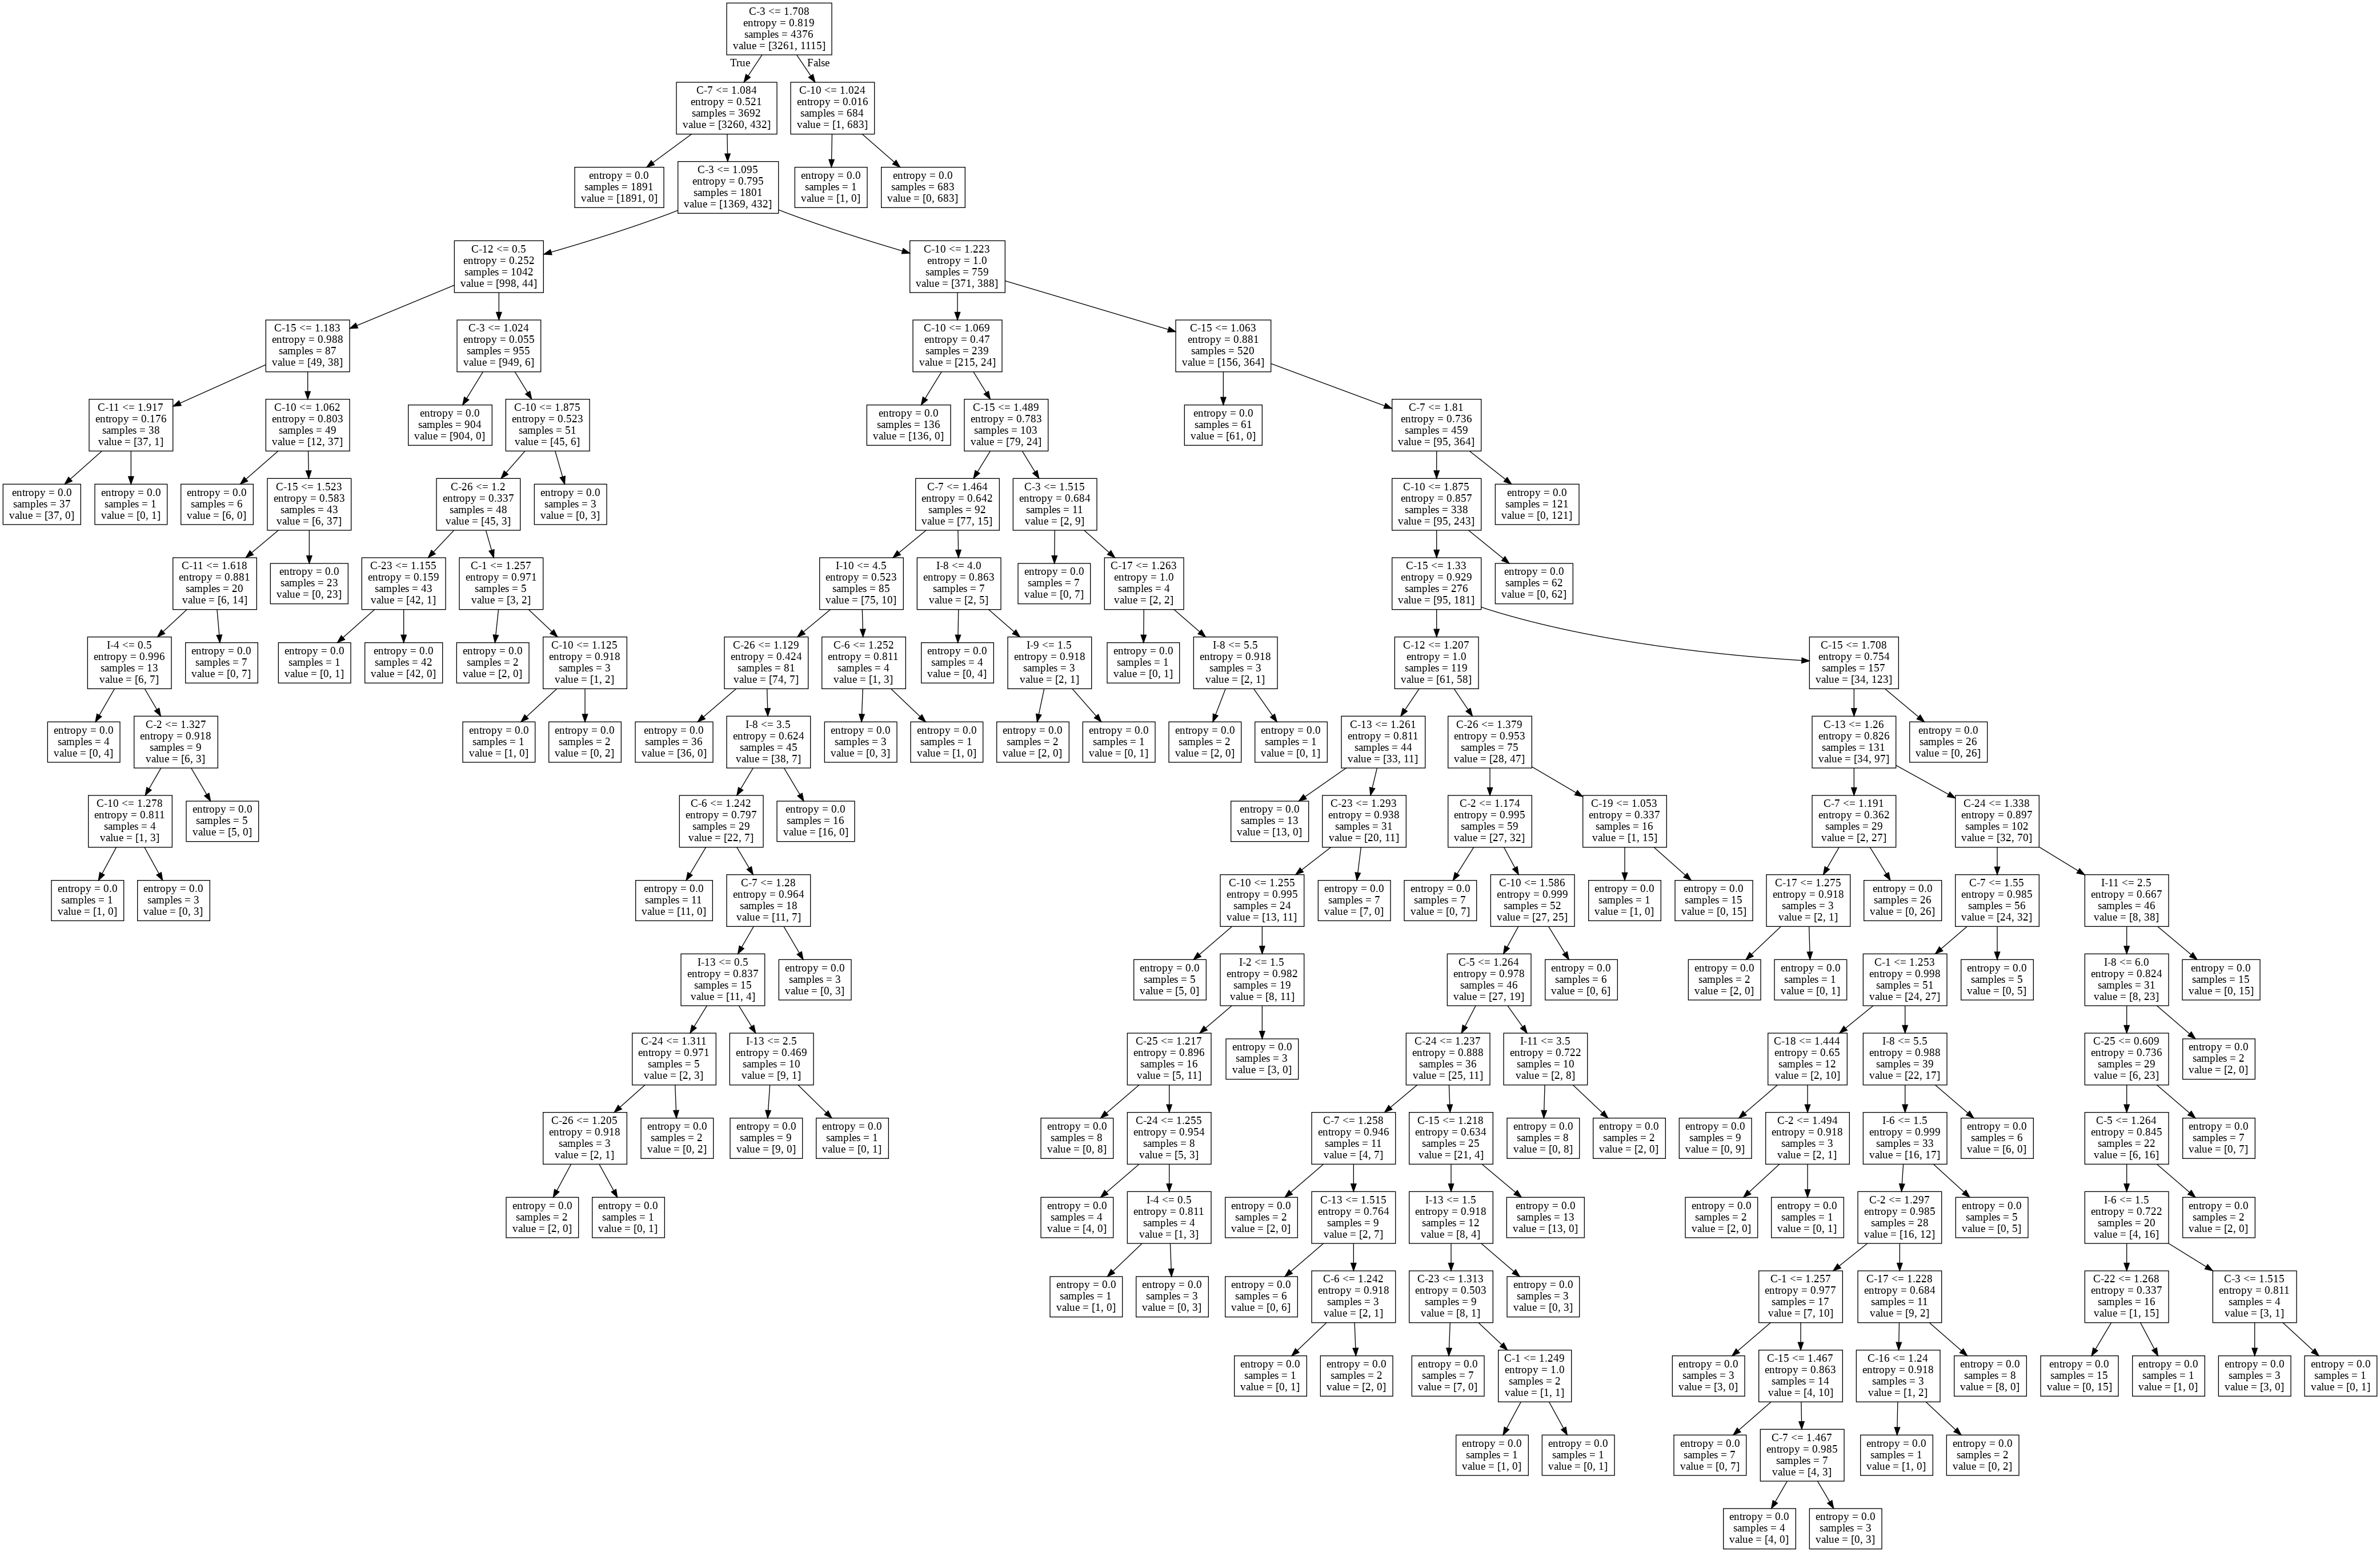

In [0]:
# Train a decision tree classifier.
dt = DecisionTreeClassifier(criterion='entropy')#,max_depth=10, min_samples_split=10) #The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.
dt.fit(train_data, train_labels)
print ('Accuracy:', dt.score(test_data, test_labels))

# Export the trained tree so we can look at it.
output_name = "toy-decisiontree.png"
dot_data = StringIO()
tree.export_graphviz(dt, out_file=dot_data, feature_names=['C-1','C-2','C-3','C-4','C-5','C-6','C-7','C-8','C-9','C-10','C-11','C-12','C-13','C-14','C-15','C-16','C-17','C-18','C-19','C-20','C-21','C-22','C-23','C-24','C-25','C-26','I-1','I-2','I-3','I-4','I-5','I-6','I-7','I-8','I-9','I-10','I-11','I-12','I-13'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

# If the export was successful, show the image.
if graph.write_png(output_name):
    print ('Output:', output_name)
    display(Image(filename=output_name))

## Toy Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt',criterion='entropy')
# Fit on training data
model.fit(train_data, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
# Actual class predictions
rf_predictions = model.predict(test_data)
print(rf_predictions)
print(sum(rf_predictions))
print(len(test_labels))
print("the predicted CTR is:", sum(rf_predictions)/len(test_labels))
# Probabilities for each class
rf_probs = model.predict_proba(test_data)[:, 1] #show the split node probability
print(rf_probs)

[1 0 0 ... 0 0 1]
274
1094
the predicted CTR is: 0.25045703839122485
[0.72 0.01 0.15 ... 0.03 0.   0.69]


In [0]:
print(model.feature_importances_)

[0.00534938 0.00746502 0.17232974 0.04464684 0.00372451 0.00327403
 0.09308293 0.00320135 0.00044963 0.11223559 0.04643319 0.14823759
 0.03707411 0.0029019  0.04048963 0.06939257 0.00495242 0.0174848
 0.00382475 0.001574   0.10904268 0.0024428  0.00351506 0.01640929
 0.00236859 0.01110503 0.00397128 0.00184482 0.00108502 0.004331
 0.00123354 0.00316631 0.00202101 0.00456181 0.00188716 0.00481049
 0.0032389  0.00131797 0.00352326]


In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

# Calculate roc auc
roc_value = roc_auc_score(test_labels, rf_probs)
print(roc_value)
rfc_cv_score = cross_val_score(model, X, Y, cv=10, scoring='roc_auc')

0.9970160740594146


ValueError: ignored

In [0]:
print("=== Confusion Matrix ===")
print(confusion_matrix(test_labels, rf_predictions))
print('\n')
print("=== Classification Report ===")
print(classification_report(test_labels, rf_predictions))
print('\n')
print("=== All AUC Scores ===")
#print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
#print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[804  11]
 [ 16 263]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       815
           1       0.96      0.94      0.95       279

    accuracy                           0.98      1094
   macro avg       0.97      0.96      0.97      1094
weighted avg       0.98      0.98      0.98      1094



=== All AUC Scores ===


=== Mean AUC Score ===


# III. EDA & Discussion of Challenges
*Determine 2-3 relevant EDA tasks that will help you make
decisions about how you implement the algorithm to be scalable. Discuss any challenges that
you anticipate based on the EDA you perform*. 

##Data Introduction##
(Pauline)
The dataset contains feature values and click feedback for millions of display ads served by Criteo.  The training set consists of a sampled of Criteo's 7 day traffic with each row corresponds to a display ad. The first column in the train data indicates whether this ad has been clicked or not (1 = clicked, 0 = not-clicked).  The first 13 columns taking integer value represent count features, and the following 26 columns represent categorial features that have been hashed for anonymization purposes.  If a value if missing, the field is empty.  The test dataset is computed in the same way as the training set but the data is taking from next day (8th day) following training period.  The first column of the test set has been removed for valuation purpose.  

In [0]:
# data = open('gdrive/My Drive/w261_KSA/test.txt')
# print(data.read(5000))

##Summary Statistics##


In [0]:
pd.read_pickle('gdrive/My Drive/w261_KSA/summary.pkl')

,Feature #,Type,Min,Max,Mean,SD,# of Non-NAs,% of NAs,# of Distinct Elements
0,1,Integer,0.0,5775.0,3.501900,9.450966,20034679,0.453686,611
1,2,Integer,-3.0,257675.0,105.858044,391.855362,36672431,0.000000,8970
2,3,Integer,0.0,65535.0,26.912787,399.101940,28802977,0.214588,13007
3,4,Integer,0.0,969.0,7.323338,8.795826,28723115,0.216765,467
4,5,Integer,0.0,2693697.0,18543.241181,69345.743561,35726013,0.025807,443808
5,6,Integer,0.0,431037.0,116.059593,384.187822,28468844,0.223699,10881
6,7,Integer,0.0,34536.0,16.328205,65.649680,35085210,0.043281,3911
7,8,Integer,0.0,6047.0,12.515552,16.565806,36654228,0.000496,1245
8,9,Integer,0.0,29019.0,106.101332,220.392298,35085210,0.043281,6954
9,10,Integer,0.0,11.0,0.617466,0.684019,20034679,0.453686,12


(Joanna)
## Missing Values
The issue of missing values is definitely a problem for this dataset. In the training set (80% of the total dataset), there are a total of 36,672,431 rows of data. Only 605,255 rows  (1.65%) contain non missing values in every field. 

Features 2, 14, 15, 18, 20, 21, 22, 23, 24, 26, 27, 28, 30, 31, and 36 have no missing values at all. Features 12 and 35 both have a significant portion of missing values (> 76%). Features 1, 10, 32, 33, 38, 39 contain 44-45% of missing values. We are also seeing similarities in the following features: 

1) features 7, 9, 11 with the same percentage (4.328%)

2) features 1, 10 with the same percentage (45.369%)

3) features 16, 17, 25, 29, 34, 37 with the same percentage (3.403%)

4) features 32, 33, 38, 39 with the same percentage (44.005%)

## Histogram Data

Feature 1: ([0, 825, 1650, 2475, 3300, 4125, 4950, 5775], [20034646, 27, 4, 0, 1, 0, 1])

Feature 2: ([-3.0, 36808.142857142855, 73619.28571428571, 110430.42857142857, 147241.57142857142, 184052.71428571426, 220863.85714285713, 257675], [36672430, 0, 0, 0, 0, 0, 1])

Feature 3: ([0.0, 9362.142857142857, 18724.285714285714, 28086.428571428572, 37448.57142857143, 46810.71428571428, 56172.857142857145, 65535], [28796242, 2822, 2174, 1319, 181, 43, 196])

Feature 4: ([0.0, 138.42857142857142, 276.85714285714283, 415.2857142857142, 553.7142857142857, 692.1428571428571, 830.5714285714284, 969], [28721914, 890, 209, 51, 31, 17, 3])

Feature 5: ([0.0, 384813.85714285716, 769627.7142857143, 1154441.5714285714, 1539255.4285714286, 1924069.285714286, 2308883.1428571427, 2693697], [35421053, 252065, 41600, 8303, 2557, 343, 92])

Feature 6: ([0.0, 61576.71428571428, 123153.42857142857, 184730.14285714284, 246306.85714285713, 307883.5714285714, 369460.2857142857, 431037], [28468797, 37, 3, 2, 2, 1, 2])

Feature 7: ([0.0, 4933.714285714285, 9867.42857142857, 14801.142857142855, 19734.85714285714, 24668.571428571428, 29602.28571428571, 34536], [35084932, 255, 18, 2, 1, 1, 1])

Feature 8: ([0.0, 863.8571428571429, 1727.7142857142858, 2591.5714285714284, 3455.4285714285716, 4319.285714285715, 5183.142857142857, 6047], [36653724, 255, 82, 85, 50, 25, 7])

Feature 9: ([0.0, 4145.571428571428, 8291.142857142857, 12436.714285714286, 16582.285714285714, 20727.85714285714, 24873.428571428572, 29019], [35079239, 5585, 335, 38, 10, 1, 2])

Feature 10: ([0.0, 1.5714285714285714, 3.142857142857143, 4.714285714285714, 6.285714285714286, 7.857142857142857, 9.428571428571429, 11], [18463627, 1519972, 41281, 9424, 296, 77, 2])

Feature 11: ([0, 33, 66, 99, 132, 165, 198, 231], [34881097, 184995, 17214, 1806, 92, 5, 1])

Feature 12: ([0.0, 572.5714285714286, 1145.142857142857, 1717.7142857142858, 2290.285714285714, 2862.8571428571427, 3435.4285714285716, 4008], [8613920, 19, 3, 2, 0, 0, 2])

Feature 13: ([0.0, 1056.142857142857, 2112.285714285714, 3168.4285714285716, 4224.571428571428, 5280.714285714285, 6336.857142857143, 7393], [28722684, 204, 114, 80, 21, 4, 8])


##Data Challenges
- have very little information about the features - how to build intuition on whether or not what we are seeing makes sense?
- categorical data? One-hot encoding potentially get very large
- what to do with missing values?

In [0]:
# # Load data from the CSV
# df = pd.read_csv('gdrive/My Drive/w261_KSA/train.txt')

# # Shuffle the data
# df = df.sample(frac=1).reset_index(drop=True)

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q http://mirrors.viethosting.com/apache/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
# !tar xf spark-2.4.4-bin-hadoop2.7.tgz
# !pip install -q findspark

In [0]:
#!rm -r spark-2.4.4-bin-hadoop2.7
# !ls

gdrive	sample_data  spark-2.4.4-bin-hadoop2.7	spark-2.4.4-bin-hadoop2.7.tgz


In [0]:
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-2.3.2-bin-hadoop2.7"

In [0]:
# import findspark
# findspark.init()
# from pyspark.sql import SparkSession
# spark = SparkSession.builder.master("local[*]").getOrCreate()

IndexError: ignored

# IV. Algorithm Implementation
*Develop a ‘homegrown’ implementation of the algorithm, apply it to the training dataset and evaluate your results on the test set.*

we can use sparkML but need to write about exactly how this works. 

##One Hot Encoding (OHE) DO NOT DO THIS


https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/2799933550853697/3228118447252433/2202577924924539/latest.html

https://yashuseth.blog/2017/12/14/how-to-one-hot-encode-categorical-variables-of-a-large-dataset-in-python/

#V. Application of Course Concepts
Pick 3-5 key course concepts and discuss how your work on
this assignment illustrates an understanding of these concepts.

Just write about how we apply course concepts.